##### **Analyse des données EEG**
##### --------------------------------
##### Dans ce notebook, nous allons explorer les étapes fondamentales du traitement des signaux EEG.
##### Nous utiliserons la bibliothèque MNE-Python pour charger, visualiser, filtrer et analyser les données EEG.
##### De plus, nous effectuerons une suppression des artefacts à l'aide de l'Analyse en Composantes Indépendantes (ICA)
##### et examinerons la Densité Spectrale de Puissance (PSD) pour comprendre la composition fréquentielle des signaux EEG.
##### Enfin, nous générerons un signal EEG synthétique et analyserons ses propriétés spectrales.
#####
##### **Qu'est-ce que l'EEG ?**
##### L'électroencéphalographie (EEG) est une technique de mesure de l'activité électrique du cerveau à l'aide d'électrodes placées sur le cuir chevelu.
##### Elle est utilisée pour diagnostiquer des troubles neurologiques, étudier le fonctionnement cérébral et analyser les états de vigilance.
##### 
##### **Gradiomètres et Magnétomètres**
##### En plus des électrodes EEG, certaines études utilisent la magnétoencéphalographie (MEG), qui capte les champs magnétiques cérébraux.
##### - Les **magnétomètres** mesurent directement ces champs.
##### - Les **gradiomètres** détectent les variations du champ magnétique en réduisant le bruit externe.
##### Ces capteurs sont particulièrement utiles pour localiser avec précision l'activité cérébrale.

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

##### --- **Étape 1 : Téléchargement du jeu de données EEG** ---
##### Nous allons utiliser la bibliothèque MNE pour télécharger un jeu de données EEG d'exemple.
##### Ce jeu de données est simple et conçu pour l'apprentissage et les tests.

In [2]:
sample_data_path = mne.datasets.sample.data_path()
sample_data_file = str(sample_data_path / 'MEG/sample/sample_audvis_raw.fif')

##### --- **Étape 2 : Chargement et visualisation des données** ---
##### Chargement du jeu de données avec MNE

In [3]:
raw = mne.io.read_raw_fif(sample_data_file, preload=True)
print(raw.info)  # Affichage des métadonnées de l'enregistrement EEG

# **Interprétation des métadonnées**
# - `sfreq` : fréquence d'échantillonnage
# - `nchan` : nombre de canaux
# - `ch_names` : noms des électrodes
# Ces informations permettent de comprendre la structure des données EEG.

Opening raw data file /home/anat/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 20

##### Affichage des données EEG brutes (10 premiers canaux, durée de 10 secondes)

Using matplotlib as 2D backend.


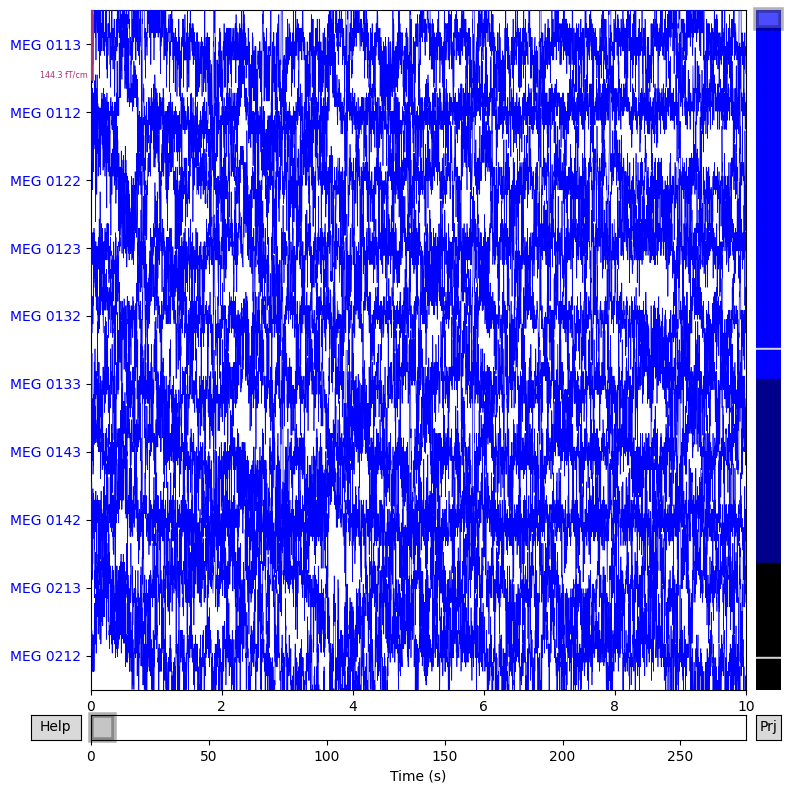

In [4]:
raw.plot(n_channels=10, duration=10, start=0, scalings='auto')
plt.show()

# **Comment interpréter ces graphes ?**
# Chaque ligne représente l'activité électrique enregistrée par une électrode. 
# Les fluctuations indiquent l'activité neuronale sous-jacente. 
# Des pics anormaux peuvent révéler des artefacts ou des anomalies neurologiques.


##### --- **Étape 3 : Analyse de base** ---
##### Tracé de la densité spectrale de puissance (PSD) pour observer le contenu fréquentiel
##### La PSD (Power Spectral Density) est utilisée pour représenter la distribution de la puissance en fonction des différentes fréquences du signal.
##### Cela permet d'identifier les rythmes dominants dans les données EEG, comme les ondes alpha (8-12 Hz) et bêta (13-30 Hz).

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


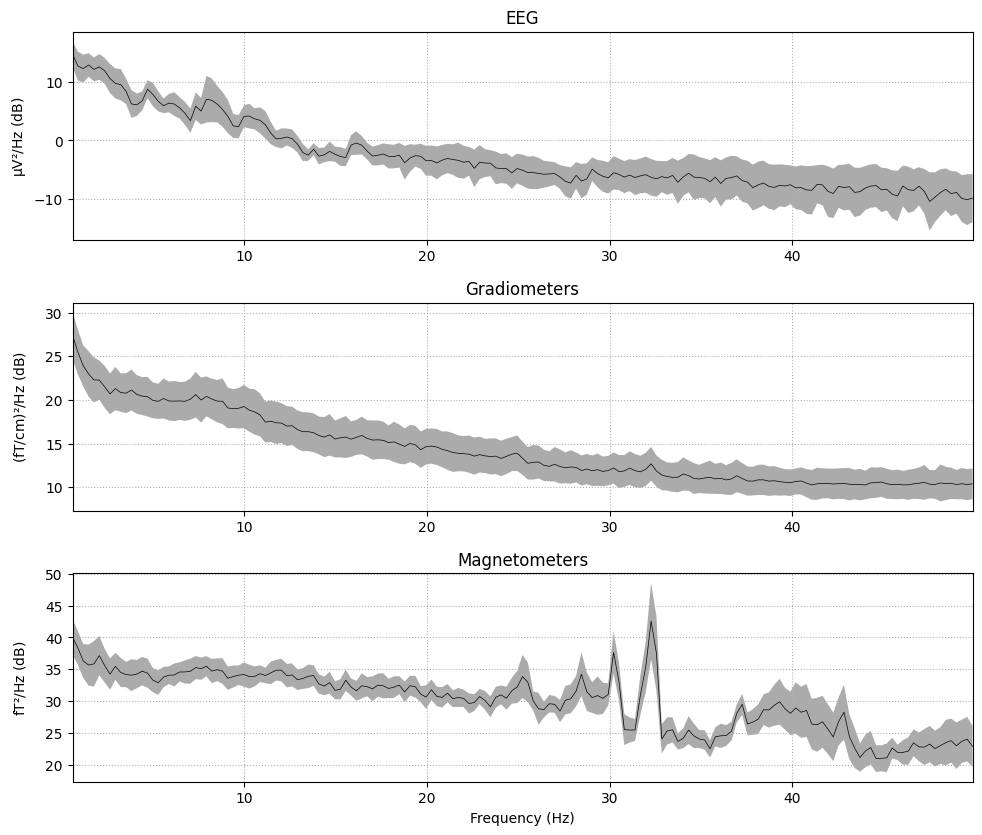

In [5]:
raw.plot_psd(fmin=0.5, fmax=50, tmin=0, tmax=60, average=True)
plt.show()

# **Interprétation du PSD**
# - Un pic dans la bande alpha (8-12 Hz) est associé à un état de repos éveillé.
# - L'activité bêta (13-30 Hz) est liée aux processus cognitifs actifs.
# - Un excès de puissance basse fréquence peut indiquer du bruit ou des artefacts.

##### --- **Étape 4 : Filtrage des données EEG** ---
##### Filtrage du signal pour supprimer les dérives basses fréquences et le bruit haute fréquence
##### Application d'un filtre passe-bande (1-40 Hz) pour conserver les fréquences EEG pertinentes

In [6]:
raw.filter(1., 40., fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    1.0s finished


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

##### Affichage des données filtrées


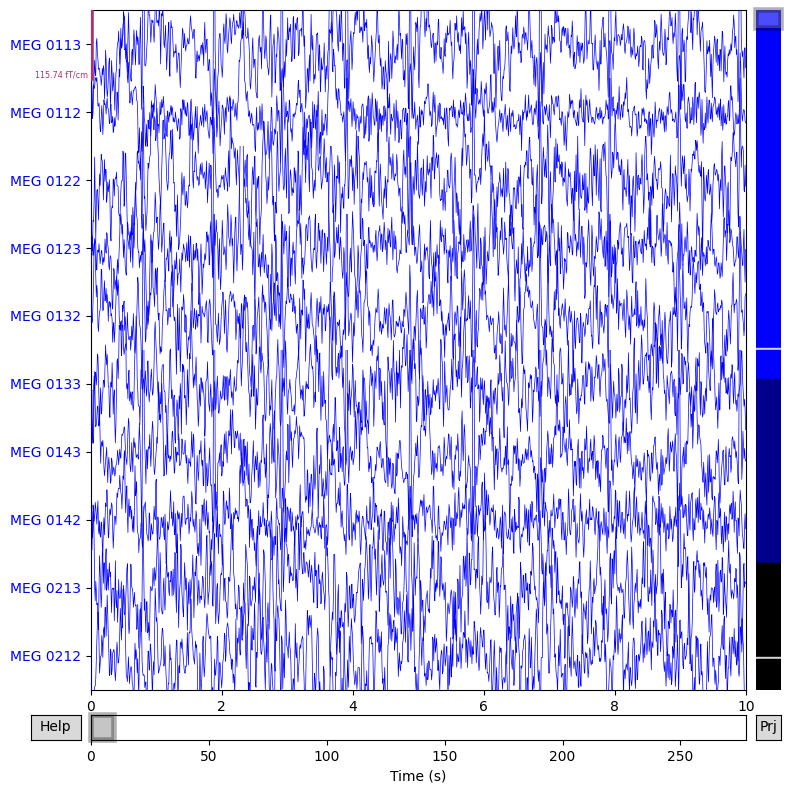

In [7]:
raw.plot(n_channels=10, duration=10, start=0, scalings='auto')
plt.show()

##### Affichage de la PSD des données filtrées

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


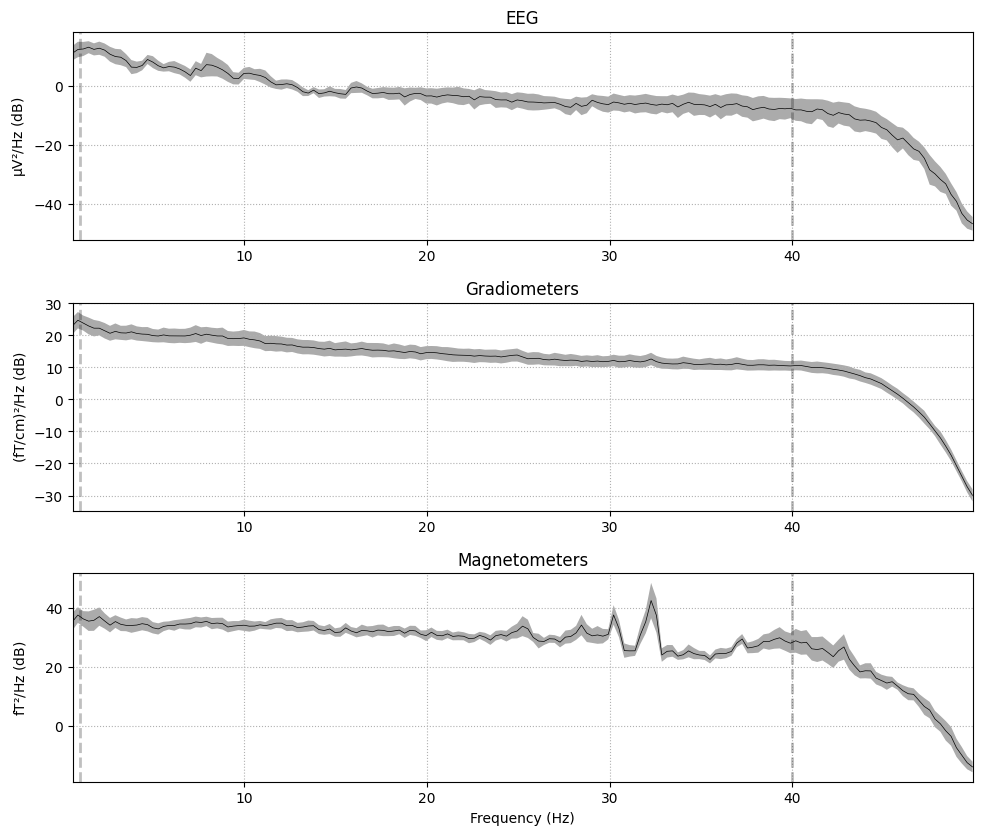

In [8]:
raw.plot_psd(fmin=0.5, fmax=50, tmin=0, tmax=60, average=True)
plt.show()

##### --- **Étape 5 : Suppression des artefacts avec l'ICA** ---
##### Application de l'Analyse en Composantes Indépendantes (ICA) pour identifier et supprimer les artefacts
##### L'ICA permet d'extraire des sources indépendantes du signal, facilitant l'élimination des artefacts tels que :
##### - Clignements des yeux
##### - Activité musculaire
##### - Bruits électriques

In [9]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97)
ica.fit(raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.0s.


Method,fastica
Fit,43 iterations on raw data (166800 samples)
ICA components,20
Available PCA components,364
Channel types,"mag, grad, eeg"
ICA components marked for exclusion,—


##### Affichage des composantes ICA pour identifier les artefacts

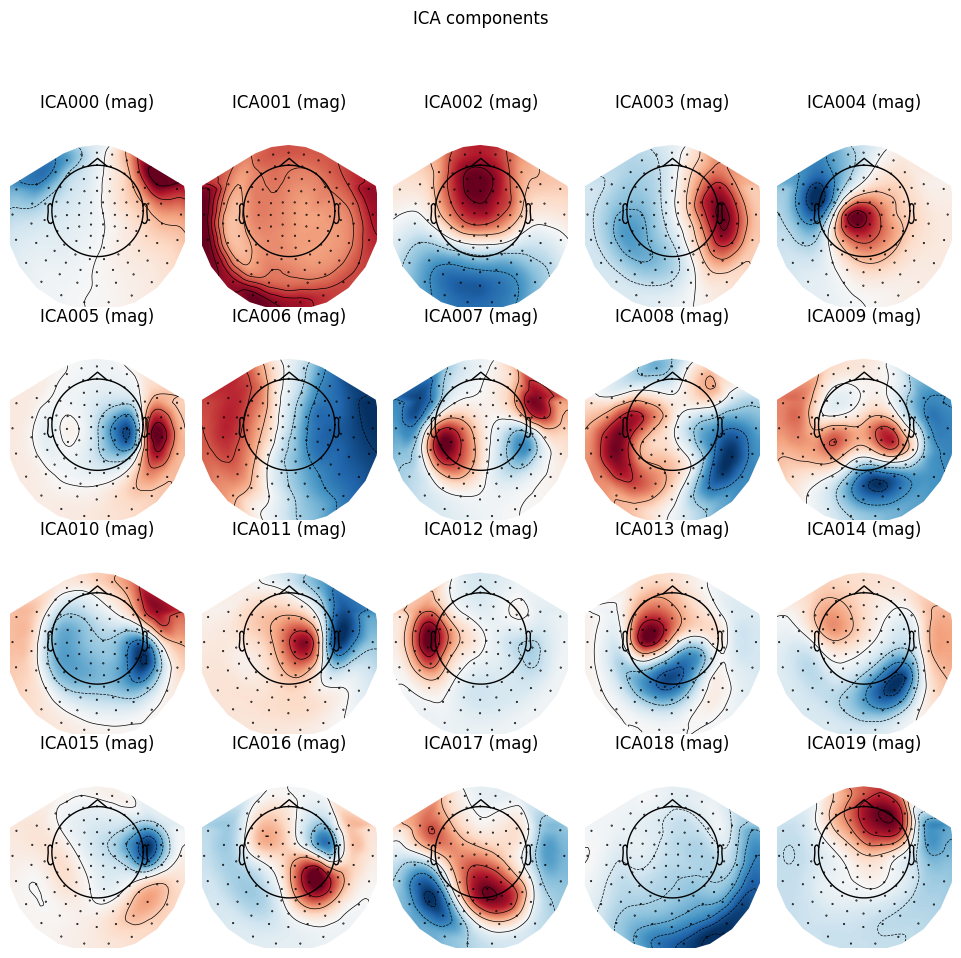

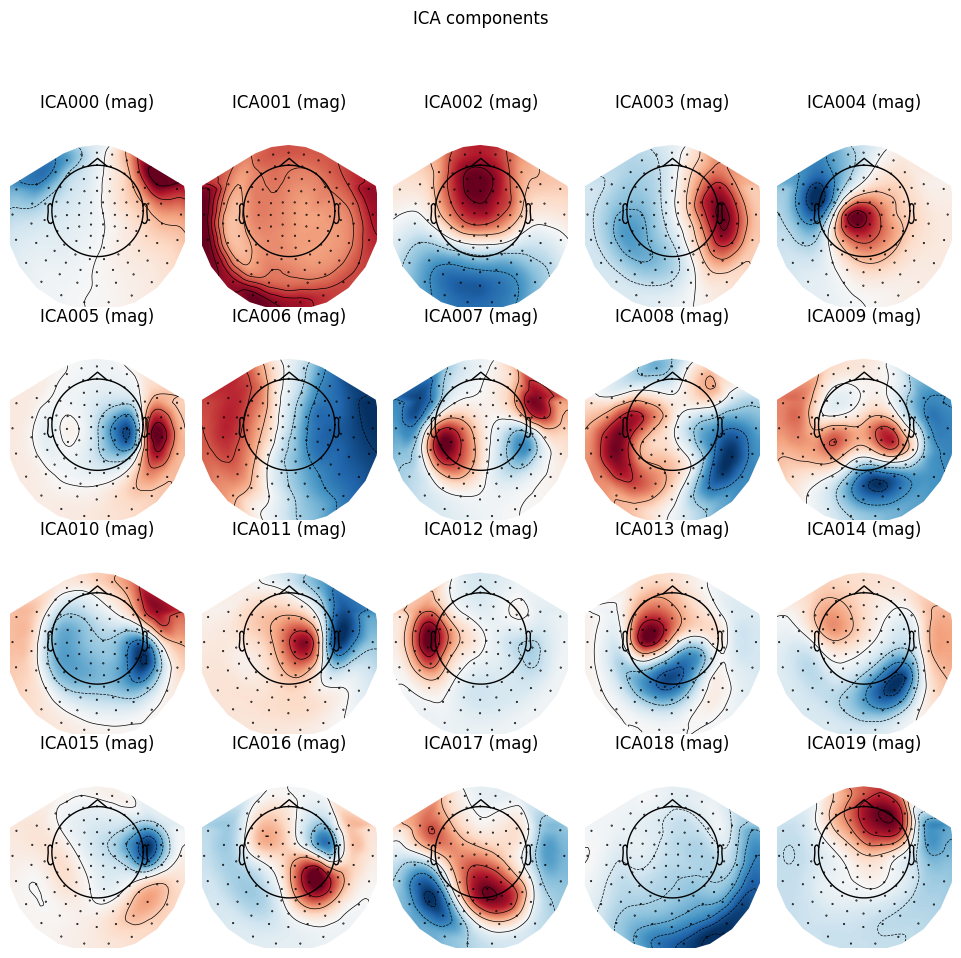

In [10]:
ica.plot_components()


##### Inspection manuelle et sélection des composantes à supprimer


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


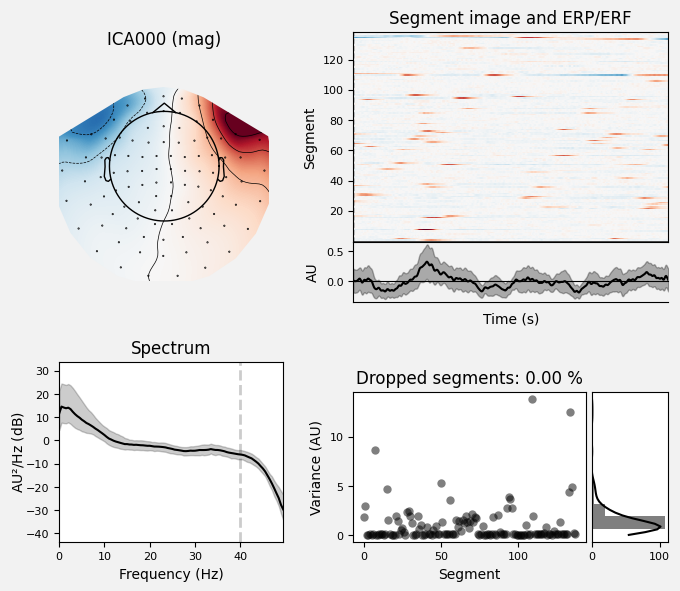

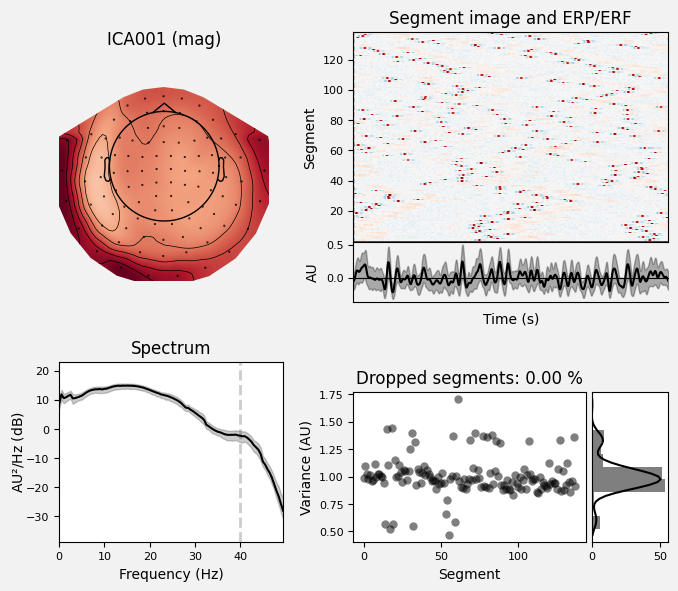

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [11]:
ica.plot_properties(raw, picks=[0, 1])


##### Exclusion des composantes identifiées comme artefacts


In [12]:
ica.exclude = [0]  # Exemple : Modifier en fonction de l'inspection
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

##### Affichage des données nettoyées


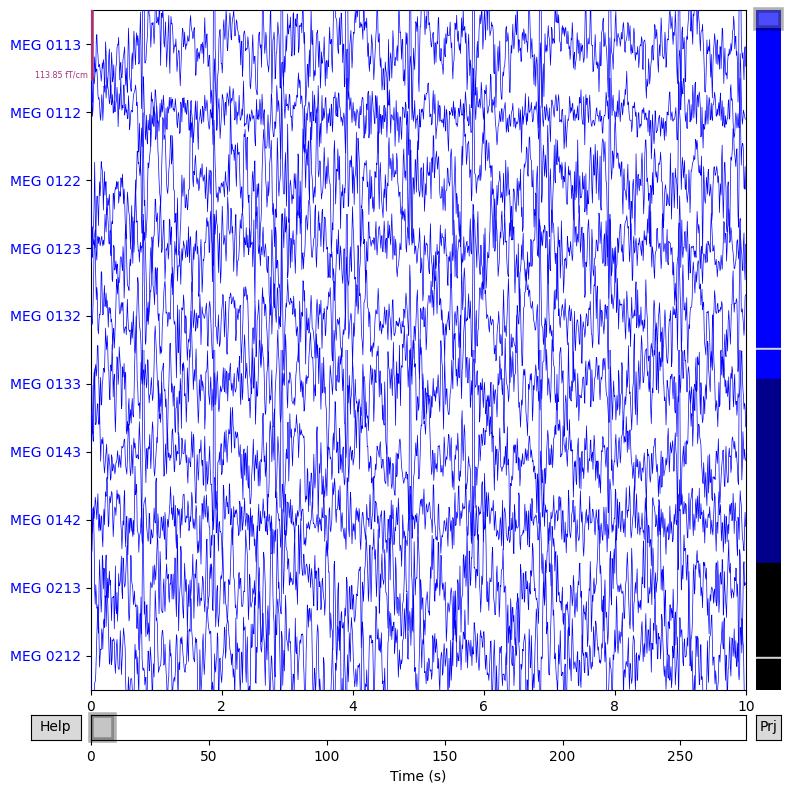

In [13]:
raw.plot(n_channels=10, duration=10, start=0, scalings='auto')
plt.show()

##### --- **Étape 6 : Signal EEG simulé et calcul de la PSD** ---
##### Création d'un signal EEG synthétique (onde sinusoïdale + bruit blanc)

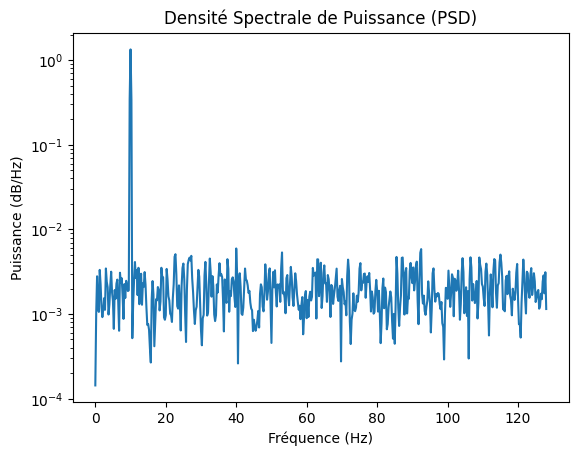

In [14]:
fs = 256  # Fréquence d'échantillonnage (Hz)
t = np.linspace(0, 10, fs * 10, endpoint=False)  # Signal de 10 secondes
eeg_signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.random.randn(len(t))  # Onde de 10 Hz + bruit

# Calcul de la PSD avec la méthode de Welch
frequencies, psd = welch(eeg_signal, fs, nperseg=1024)

# Tracé de la PSD
plt.figure()
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance (PSD)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Puissance (dB/Hz)")
plt.show()

# **Interprétation de la PSD simulée**
# Le pic principal autour de 10 Hz reflète la fréquence dominante du signal généré.
# La composante de bruit blanc se manifeste sous forme d'une distribution étalée sur toutes les fréquences.
